In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import distributions
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('poster')

# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.curdir, './utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

# Introduction

We will learn to build two approaches of probabilistic models and use sampling methods to perform inference on parameters of interest. Specifically we will discuss

- Single parameter model.
- Multiparameter model.
- Hierarchical (multilevel) model.

Multiparameter model is used as our first general way to build a probabilistic model. Whereas hierarchical models are used when we want to use data that has some hierarchical level such geographical data can be thought as being organized by countries, provinces, and cities.

# Single Parameter Model

We discuss four fundamental and widely one dimensional models:

1. **Binomial model** is motivated from counting exchangeable outcomes.
2. **Normal model** applies to random variable that is the sum of many exchangeable or independent terms, to the logarithm of all positive data, which naturally appy to observations that are modeled as product of many independent multiplicative factors.
3. **Poisson model** model the number of counts of events modeled as occuring exchangeably in all time intervals; that is, independently in time, with a constant rate of occurence.
4. **Exponential** model the waiting times of events modeled as occuring exchangeably in all time intervals.

Note that we construct more realistic probabilistic model by combinations of these basic model so it is important to get a good handle on them.

### Binomial model

The binomial distribution models naturally the situation in which we have n exchangable trials. Each is labeled as success or failure. Because of exchageability, the data can be summarized by the number of successes, denoted as y. Then we have the binomial sampling model is: $$p(y|\theta) = Bin(y|n,\theta) = \begin{pmatrix}n\\y\end{pmatrix}\theta^y(1-\theta)^{n-y}$$

We want to estimate the posterior distribution of $\theta$, the rate of success, we apply Bayes' theorem: $$p(\theta |y) \propto p(\theta)p(y|\theta))$$

If we use the uniform prior $p(\theta) = 1$ then we have the posterior distribution $p(\theta |y) = Beta(y+1, n-y + 1)$.

Once we have the posterior distribution of parameters of interests, $p(\theta |y)$, we have the following choice of summarizing it:

1. Graphical display
2. Location summaries: mean, median, mode
3. Variation summaries: standard deviation, interquartile range, other quartiles.

**Problem**:

    Placenta previa is a condition of women that may lead to complication when giving birth. According to data collected in Germany, out of 980 placenta previa births, 437 were female. How much evidence does this provide for the claim that the proportion of female births in the  population of placenta previa births is less than 0.485, the proportion of female births in the general population.


This is a natural case for the Binomial model, with $\theta$ denote the female birth rate and y is the number of female birth.  We use uniform prior $p(\theta) \propto 1$ then the posterior distribution is Beta(438, 544).

Uniform prior -> Posterior is Beta(438,544)


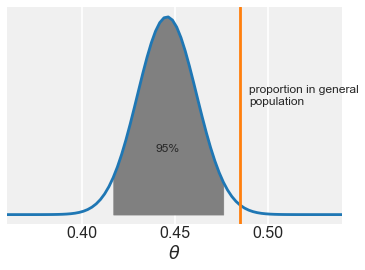

In [2]:
x = np.linspace(0.36, 0.54, 80)
dist = beta(438,544)
pd = dist.pdf(x)
print('Uniform prior -> Posterior is Beta(438,544)');
plt.plot(x, pd)
# show only x-axis
plot_tools.modify_axes.only_x()

# proportion of femal birth in general population
plt.axvline(0.485, color='C1')
plt.annotate(
    'proportion in general\npopulation',
    (0.485 + 0.005, 14),
    ha='left'  # horizontalalignment
)
x_95_idx = (x > dist.ppf(0.025)) & (x < dist.ppf(0.975))
plt.fill_between(x[x_95_idx], pd[x_95_idx], color='0.5')
plt.text(dist.median(), 8, '95%', horizontalalignment='center')
plt.xlabel(r'$\theta$')

plt.autoscale(axis='x', tight=True);

In [3]:
# posterior mean P(theta|y)
print('posterior mean of theta: ', dist.mean())
print('posterior standard deviation: ', dist.std())

posterior mean of theta:  0.4460285132382892
posterior standard deviation:  0.015854343318208036


What if we use different priors we use different priors of $\theta$

In [4]:
x = np.linspace(0.375, 0.525, 150)

# posterior with data (437,543) and uniform prior Beta(1,1)
au = 438
bu = 544
# calculate densities
pdu = beta.pdf(x, au, bu)

# compare 3 cases
# arrays of different priors:
# Beta(0.485*n, (1-0.485)*n), for n = 2, 20, 200
ap = np.array([0.485 * (2*10**i) for i in range(3)])
bp = np.array([(1-0.485) * (2*10**i) for i in range(3)])

# corresponding posteriors with data (437,543)
ai = 437 + ap
bi = 543 + bp
# calculate prior and posterior densities
pdp = beta.pdf(x, ap[:,np.newaxis], bp[:,np.newaxis])
pdi = beta.pdf(x, ai[:,np.newaxis], bi[:,np.newaxis])

Note the three nonuniform priors share the same mean 0.485. Also in the calculation of prior and posterior densities, we exploit broadcast features of numpy, ``ap[:, np.newaxis]``

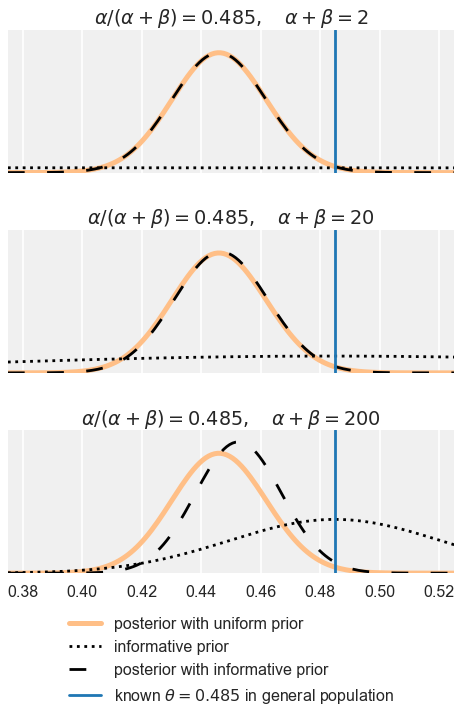

In [5]:
# plot 3 subplots
fig, axes = plt.subplots(
    nrows=3, ncols=1, sharex=True, sharey=True, figsize=(8, 10))
# show only x-axis
plot_tools.modify_axes.only_x(axes)
# manually adjust spacing
fig.subplots_adjust(hspace=0.4)

# 3 subplots
for i, ax in enumerate(axes):
    # plot three precalculated densities
    post1, = ax.plot(x, pdu, color=plot_tools.lighten('C1'), linewidth=5)
    prior, = ax.plot(x, pdp[i], 'k:')
    post2, = ax.plot(x, pdi[i], color='k', dashes=(6 , 8))
    # add vertical line
    known = ax.axvline(0.485, color='C0')
    # set the title for this subplot
    ax.set_title(
        r'$\alpha/(\alpha+\beta) = 0.485,\quad \alpha+\beta = {}$'
        .format(2*10**i)
    )
# limit x-axis
axes[0].autoscale(axis='x', tight=True)
axes[0].set_ylim((0,30))
# add legend to the last subplot
axes[-1].legend(
    (post1, prior, post2, known),
    ( 'posterior with uniform prior',
      'informative prior',
      'posterior with informative prior',
     r'known $\theta=0.485$ in general population'),
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2)
);



In the above code, we perform calculation directly on the posterior distribution because it is beta distribution and easy to do this. In many situations it is not feasible to perform calculations on the posterior density function directly. 

We now show how we can perform inference using simulation. Simulate samples from Beta(438,544), draw a histogram with quantiles, and do the same for a transformed variable.

phi 95% interval  1.096652121229503 1.4123864747960069


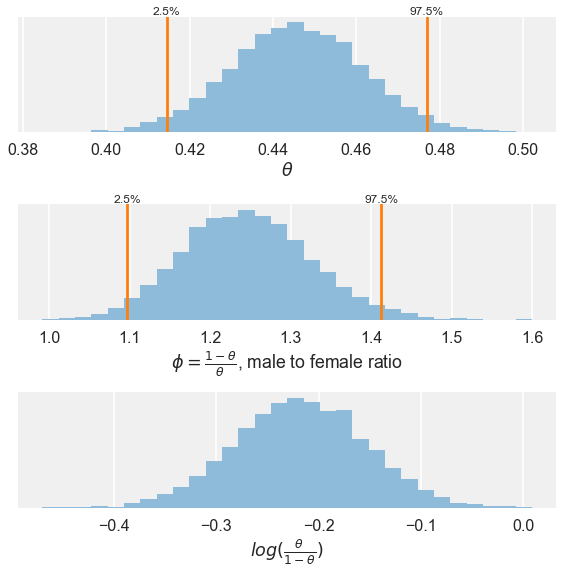

In [6]:
# plotting grid
x = np.linspace(0.36, 0.54, 150)

# draw n random samples from Beta(438,544)
n = 10000
th = beta.rvs(438, 544, size=n)  # rvs comes from `random variates`

# plot 2 subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
# show only x-axis
plot_tools.modify_axes.only_x(axes)
# manually adjust spacing
fig.subplots_adjust(hspace=0.5)

# plot histogram
axes[0].hist(th, bins=30, color=plot_tools.lighten('C0'))
# compute 2.5% and 97.5% quantile approximation using samples
th25, th975 = np.percentile(th, [2.5, 97.5])
# draw lines for these
axes[0].axvline(th25, color='C1')
axes[0].axvline(th975, color='C1')
axes[0].text(
    th25,
    axes[0].get_ylim()[1]+15,
    '2.5%',
    horizontalalignment='center'
)
axes[0].text(
    th975,
    axes[0].get_ylim()[1]+15,
    '97.5%',
    horizontalalignment='center'
)
axes[0].set_xlabel(r'$\theta$')

# plot histogram for the transformed variable
phi = (1-th)/th
axes[1].hist(phi, bins=30, color=plot_tools.lighten('C0'))
# compute 2.5% and 97.5% quantile approximation using samples
phi25, phi975 = np.percentile(phi, [2.5, 97.5])
print('phi 95% interval ', phi25, phi975)
# draw lines for these
axes[1].axvline(phi25, color='C1')
axes[1].axvline(phi975, color='C1')
axes[1].text(
    phi25,
    axes[1].get_ylim()[1]+15,
    '2.5%',
     horizontalalignment='center'
)
axes[1].text(
    phi975,
    axes[1].get_ylim()[1]+15,
    '97.5%',
    horizontalalignment='center'
)
axes[1].set_xlabel(r'$\phi = \frac{1-\theta}{\theta}$, male to female ratio');

logit_transform = np.log(th/(1-th))
axes[2].hist(logit_transform, bins=30, color=plot_tools.lighten('C0'))
axes[2].set_xlabel(r'$log(\frac{\theta}{1-\theta})$')
plt.tight_layout()

$\phi$ is the ratio of boy to girl births. From the second plot above, we have the 95% confidence interval $[1.09712531305, 1.41129270954]$ that more boys are born.

What about using non-conjugate prior distribution? Calculate the posterior distribution on a discrete grid of points by multiplying the likelihood and a non-conjugate prior at each point, and normalizing over the points. Simulate samples from the resulting non-standard posterior distribution using inverse cdf using the discrete grid.


In [7]:
# data (437,543)
a = 437
b = 543

# grid of nx points
nx = 1000
x = np.linspace(0, 1, nx)

# compute density of non-conjugate prior in grid
# this non-conjugate prior is same as in Figure 2.4 in the book
pp = np.ones(nx)
ascent = (0.385 <= x) & (x <= 0.485)
descent = (0.485 <= x) & (x <= 0.585)
pm = 11
pp[ascent] = np.linspace(1, pm, np.count_nonzero(ascent))
pp[descent] = np.linspace(pm, 1, np.count_nonzero(descent))
# normalize the prior
pp /= np.sum(pp)

# unnormalised non-conjugate posterior in grid
po = beta.pdf(x, a, b)*pp
po /= np.sum(po)
# cumulative
pc = np.cumsum(po)

# inverse-cdf sampling of posterior
# get n uniform random numbers from [0,1]
n = 10000
r = np.random.rand(n)
# map each r into corresponding grid point x:
# [0, pc[0]) map into x[0] and [pc[i-1], pc[i]), i>0, map into x[i]
# rr = reverse random
rr = x[np.sum(pc[:,np.newaxis] < r, axis=0)]

In the last part of the above code, we perform sampling from the genereated (discrete) posterior distribution. The theory behind this process is the following theorem (Casella, p53):

Theorem 2.1.4
Let X have a continous cdf $F_{X}(x)$ and define the random variable as $Y = F_X(X)$, then X is uniformly distributed on (0,1), that is $P(Y \leq y) = y, 0 \leq y \leq 1$.

We can use this theorem to generate randome samples from a particular distribution. If it is required to generate an observation x from a popluation with cdf $F_X$, we need only generate a uniform random number u, between 0 and 1 and solve for x in the equation $F_X(x) = y$.

In fact $x = F_X^{-1}(y)$, where $ F_X^{-1}(y) = inf\{x: F_X(x) \geq y\}$. This was implemented as

`rr = x[np.sum(pc[:,np.newaxis] < r, axis=0)]`

For simplicity consider r as a number and pc as a column vector then pc < r give us the column of True/False values. By summing over the row, we will determine the index into the x array. This is the sample from posterior distribution: r-->x.

- pc as a column vector: `pc[:,np.newaxis] < r`
- numpy broadcasting mechanism is at work here: `pc[:,np.newaxis] < r`

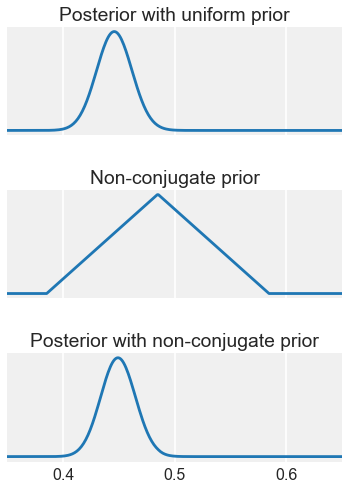

In [8]:
# plot 3 subplots
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
# show only x-axis
plot_tools.modify_axes.only_x(axes)
# manually adjust spacing
fig.subplots_adjust(hspace=0.5)

# posterior with uniform prior Beta(1,1)
axes[0].plot(x, beta.pdf(x, a+1, b+1))
axes[0].set_title('Posterior with uniform prior')

# non-conjugate prior
axes[1].plot(x, pp)
axes[1].set_title('Non-conjugate prior')

# posterior with non-conjugate prior
axes[2].plot(x, po)
axes[2].set_title('Posterior with non-conjugate prior')

# cosmetics
#for ax in axes:
#    ax.set_ylim((0, ax.get_ylim()[1]))

# set custom x-limits
axes[0].set_xlim((0.35, 0.65));

Text(0.5,1,'inverse cdf sampling')

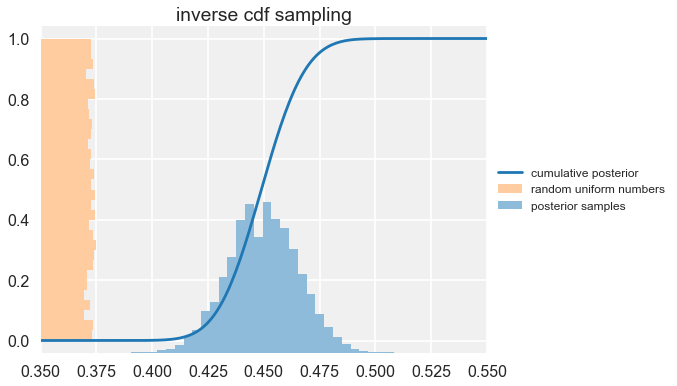

In [9]:
# plot samples

# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])
plt.figure(figsize=(8, 6))

# calculate histograms and scale them into the same figure
hist_r = np.histogram(r, bins=30)
hist_rr = np.histogram(rr, bins=30)
plt.barh(
    hist_r[1][:-1],
    hist_r[0]*0.025/hist_r[0].max(),
    height=hist_r[1][1]-hist_r[1][0],
    left=0.35,
    align='edge',
    color=plot_tools.lighten('C1', 0.6),
    label='random uniform numbers'
)
plt.bar(
    hist_rr[1][:-1],
    hist_rr[0]*0.5/hist_rr[0].max(),
    width=hist_rr[1][1]-hist_rr[1][0],
    bottom=-0.04,
    align='edge',
    color=plot_tools.lighten('C0'),
    label='posterior samples'
)
# plot cumulative posterior
plt.plot(
    x,
    pc,
    color='C0',
    label='cumulative posterior'
)
# turn spines off

# legend
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.0, 0.5),
    fontsize=12
)
# set limits
plt.xlim((0.35, 0.55))
plt.ylim((-0.04, 1.04));
plt.gca().set_title('inverse cdf sampling')

### Normal model

Normal model is justified by the central limit theorem. Moreover it serves as a good approximiation for many likelihood function that is less analytically convenient. We can also build more complex model out of normal models to fit the data better.For example, gaussian mixture models.

**Full Problem**: Given a data set $\{y_n\}$, $n = 1\dots N$ that are drawn from an unknown Gaussian distribution $N(\mu, \sigma^2)$. How can we infer the values of $\mu$ and $\sigma^2$.

Inferring the values of parameters means computing their posterior distribution (at least in our probabilistic inference context). Ideally, from data sets, we should compute both posterior distributions of $\mu$ and $\sigma$. But to simply the problem we will assume that $\sigma^2$ is provided and our job is to compute posterior distribution of only $\mu$. Note that $\mu$ plays the role of $\theta$, the unknown parameter of interest. In the section of **multi-parameter model**, we will come back to the full problem. 

**Normal model with unknown mean and known variance**

As in any Bayesian setting, we need to setup a prior distribution of $\mu$ and hopes to compute posterior distribution $p(\mu|y)$. Recall that 

$$p(\mu |y) \propto p(\mu)p(y|\mu)$$

As we will see it is a good idea to pick the prior distribution to be a guassian distribution $N(\mu_o, \tau_o^2)$. This will be a conjugate prior of the likelihood $p(y|\mu)$ given by:

$$p(y|\mu) \propto exp(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(y_n - \mu)^2))$$

Hence,

$$\begin{align}p(\mu|y) &\propto p(\mu)p(y|\mu)\\
                         &\propto exp(-\frac{1}{2\tau_0^2}(\mu - \mu_o)^2))exp(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(y_n - \mu)^2))
\end{align}$$

We recognize that $\mu|y \sim N(\mu_N, \tau_N^2)$, where

$$\mu_N = \frac{\frac{1}{\tau_0^2}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}}$$

and

$$\frac{1}{\tau_n^2} = \frac{1}{\tau_0^2} + \frac{n}{\sigma^2}$$

The above formula has a natural explanation, the mean is the average between prior mean and data mean, weighted by precision of prior and precision of data. Whereas, the precision is the sum of prior precision and data precision. Please see the multi-parameter model Section to see a demo.

**Normal model with known mean and unknown variance**

This model is not important by itself but when combining with other model such as the one above, we can build more complex model. Again proceeding with specification of prior, likelihood, we can compute the posterior distribution of the variance. We have:

The likelihood:

$$\begin{align}p(y|\sigma^2) &\propto \sigma^{-n}exp(-\frac{1}{2\sigma^2}\sum_{n-1}^{N}(y_n - \mu))\\
                             &\propto (\sigma^2)exp(-\frac{n}{2\sigma^2}v)
\end{align}$$

where $v$ is the sufficient statistics $v = \frac{1}{n}\sum_{n=1}^{N}(y_n - \mu)^2$

The prior:

$$p(\sigma^2) \propto (\sigma^2)^{-(\alpha + 1)}exp(\frac{-\beta}{\sigma^2})$$

This is inverse-gamma distribution with two parameters $\alpha$ and $\beta$. We can also an equivalent distribution called scaled-inverse chi square, $\sigma^2 \sim Inv{-}\chi^2(\nu_0, \sigma_0^2)$.

After some algebraic manipulation we have the posterior distribution of $\sigma^2$ is a scaled inverse chi square $$\sigma^2|y \sim Inv{-}\chi^2(\nu_0 + n, \frac{v_0\sigma_0^2 + nv}{\nu_0 + n})$$

### Poisson Model
Poisson distribution is suitable to model data taking the form of counts. If a data point y follows the Poisson distribution with the rate $\theta$, the the probability of a single observation y is:

$$p(y|\theta) = \frac{\theta^ye^{-\theta}}{y!}, \text{y = 0,1,2,...}$$

Given a series of N independent obserivations $y = (y_1, \dots, y_N)$, we have the likelihood is $$p(y|\theta) = \prod_{n=1}^{N}\frac{1}{y_n!}\theta^{y_n}e^{-\theta} \propto \theta^{t(y)}e^{-n\theta}$$

Using the prior distribution for $\theta$ as $Gamma(\alpha, \beta)$ then we have the posterior distribution $\theta |y \sim Gamma(\alpha + n\bar{y}, \beta + n)$

**Problem**: Suppose we have a city whose population is 200,000 people. We observer there are 3 people that died of asthma. We want to estimate the underlying asthma mortality rate of this city.

**Solution**: We use Poisson distribution to model the number of people, y, that died of asthma. So in our case we have $y = 3$, we want to infer $\theta$.

Suppose the prior distribution is $\theta \sim Gamma(\alpha,\beta)$

Under the Poisson models the number of deaths, y, in a city of 200,000 in one year, can be expressed as $Poisson(2\theta)$, where $\theta$ represents the truth underlying long-term asthma mortality rate in the city (measusred in cases per 100,000 persons per year). We the have

$$p(y|\theta) \propto \theta^{\sum_{i=1}^{n}y_i}e^{-(\sum_{i=1}^{n}x_i)\theta}$$

and the resulting posterior distribution is:

$$\theta |y \sim Gamma(\alpha + \sum_{i=1}^{n}y_i, \beta + \sum_{i=1}^{n}x_i)$$


Now we have, in our city,  $\sum_{i=1}^{n}y_i = 3$ and $\sum_{i=1}^{n}x_i = 2$ (single observation). Using prior as $Gamma(3,5)$

Note that for ``gamma`` of scipy, we need two parameters:
- shape parameter a,  with $a = \alpha$
- scale parameter $1/\lambda$, with $\beta = \lambda$

So in order to create $Gamma(\alpha, \beta)$, in scipy, we need to construct ``gamma(a=alpha, scale=1/beta)

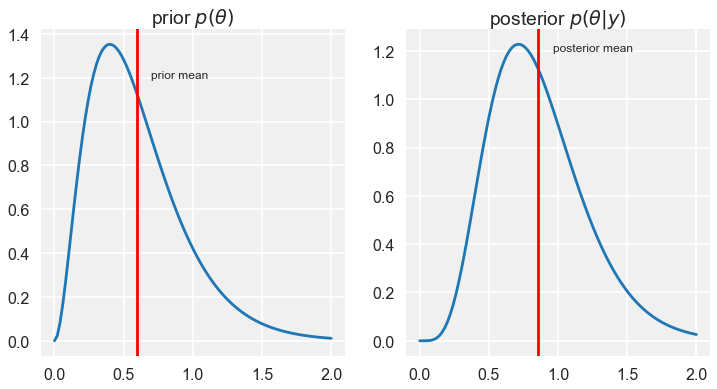

In [10]:
# prior
alpha = 3
beta = 5
theta = np.linspace(0, 2, 100)
prior = gamma.pdf(theta, a=alpha, scale=1/beta)

# posterior
sum_y = 3
sum_x = 2
post = gamma.pdf(theta, a= alpha + sum_y, scale=1/(beta + sum_x))
# visualize
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(nrows=1, ncols=2)
axes[0].plot(theta, prior)
axes[0].axvline(alpha/beta, 0, 1.4, color='r');
axes[0].set_title(r'prior $p(\theta)$');
axes[0].annotate(
    'prior mean',
    (0.6 + 0.1, 1.2),
    ha='left'  # horizontalalignment
)
axes[1].plot(theta, post)
axes[1].axvline((alpha + sum_y) / (beta + sum_x), 0, 1.4, color='r')
axes[1].set_title(r'posterior $p(\theta|y)$');
axes[1].annotate(
    'posterior mean',
    (0.86 + 0.1, 1.2),
    ha='left'  # horizontalalignment
);

In [11]:
print('p(theta >1 |y) = ',  1- gamma(alpha + sum_y, scale=1/(beta + sum_x)).cdf(1))

p(theta >1 |y) =  0.3007082761743609


### Exponetial model

The exponential model is suitable for continous data, positive real-valued, often measure on a time scale, for example waiting time. The sampling distribution of an outcome y, given parameter $\theta$, is $$p(y|\theta) = \theta exp(-y\theta)$$ for y > 0.

This distribution has the memoryless property that makes it suitable to model survival data: $p(y>t+s|y>s, \theta) = p(y>t |\theta)$ for any s,t

# Posterior as comprise between data and prior information

Before we introduce multi-parameter model, it is instructive to discuss the relationship among prior, data, and posterior distribution, which is describe with the following two formlas:
$$E(\theta) = E(E(\theta|y))$$

and
$$var(\theta) = E(var(\theta|y)) + var(E(\theta|y))$$

The first formula says that the prior mean of $\theta$ is the average of all possible posterior mean over the distribution of possible data.

The second formula is more interesting, it says that the posterior variance on average (first term on LHS) is smaller then the prior posterior. This makes sense because knowing the data $y$ should reduce our uncertainty (variance) about $\theta$. 

# Multiparameter Model

In inference problems, the model generally has multiple parameters. Nevertheless, we are interested, in most cases, in only a handful of them. Therefore the ultimate goal is to compute the marginal posterior distribution of the particular parameters of interest. The are two main approach to compute this marginal distribution:

1. Analytically: Derive the joint posterior distribution of **all** unknowns and then integrate out the unknowns that are not of immediate interest to obtain the desired marginal.
2. Numerically: Using simulation, we draw samples from the joint posterior and then look at the parameters of interest and ignore the values of other unknowns.

**Problem**: Given data $\mathcal{D} = \{(y_i)\}$, assuming that these data points were generated by a hidden Gaussian distribution $N(\mu, \sigma^2)$. Estimate its parameters.

**Solution**:

We use a noninformation prior $$p(\mu, \sigma) \propto (\sigma^2)^{-1}$$

Then $$p(\mu,\sigma^2 | y) \propto \sigma^{-n-2}exp(-\frac{1}{2\sigma^2}[(n-1)s^2 + n(\bar{y} - \mu)^2])$$

where $$s^2  = \frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2$$

is the sample variance of the data $\mathcal{D} = \{(y_i)\}$.

We also have $$\mu|\sigma^2,y \sim N(\bar{y}, \sigma^2/n)$$

and $$\sigma^2|y = Inv\text{-}\chi^2(n-1, \sigma^2)$$

Note that the scaled inverse chi square distribution is not implemented by scipy. So we need to implement ourself. Its formula is as follow:

$$Inv\text{-}\chi^2(\nu, s^2) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}s^{\nu}\theta^{-(\nu/2 + 1)}exp(\frac{-\nu s^2}{2\theta})$$

This is the same as $Inv\text{-}gamma(\alpha=\frac{\nu}{2}, \beta = \frac{\nu}{2}s^2)$ and ``scipy`` provided this function.

We are normally interested in the mean $\mu$. Hence, we want to compute the marginal posterior distribution of $\mu$: $$p(\mu|y) = \int_{0}^{\infty}p(\mu, \sigma^2|y)d\sigma^2$$

Note that we normally do not compute the above integration. But in this case, we do have a closed form for this integration. In case of no closed form availability, we perform sampling. 

The closed form is as follows $$\frac{\mu - \bar{y}}{s/\sqrt{n}}\big|y \sim t_{n-1}$$, where $t_{n-1}$ denotes the standard (Student) t density (location = 0, scale = 1), with n-1 degrees of freedom.

In the above discussion, we have closed forms for all probabilities. In general case, we do not have. We resolve to simulation. In the following code we will use this approach.

In [59]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the sample estimate
my = np.mean(y)

In [67]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

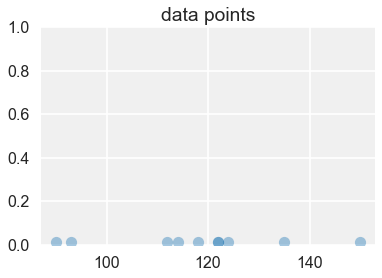

In [68]:
plt.plot(y, np.ones_like(y)/80, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');

In [69]:
# factorize the joint posterior p(mu,sigma2|y) to p(sigma2|y)p(mu|sigma2,y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)
# sample from p(mu|sigma2,y)
# student-t dist is replaced by standard normal
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)
# display sigma instead of sigma2
sigma = np.sqrt(sigma2)
# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = rng.randn(*mu.shape)*sigma + mu

To understand the sampling of mu. Note that:

$$\mu|\sigma^2,y \sim N(\bar{\mu}, \sigma^2/n)$$ which means

$$\mu = \bar{y} + \frac{\sigma}{\sqrt{n}}X,$$ where $X \sim \cal{N}(0,1)$

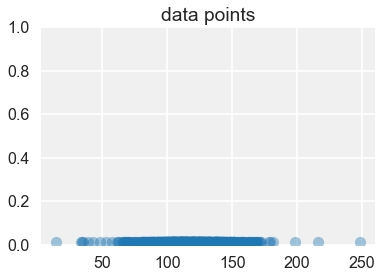

In [70]:
plt.plot(ynew, np.ones_like(ynew)/80, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');

In [71]:
# for mu compute the density in these points
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis]

# compute the exact marginal density for mu
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# z=(x-mean(y))/sqrt(s2/n), see BDA3 p. 21
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

# estimate the marginal density for mu using samples and an ad hoc Gaussian
# kernel approximation
pk_mu = stats.gaussian_kde(mu).evaluate(t1)

# compute the exact marginal density for sigma
# multiplication by 2*t2 is due to the transformation of variable
# z=t2^2, see BDA3 p. 21
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2
# N.B. this was already calculated in the joint distribution case

# estimate the marginal density for sigma using samples and an ad hoc Gaussian
# kernel approximation
pk_sigma = stats.gaussian_kde(sigma).evaluate(t2)

# compute the exact predictive density
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# see BDA3 p. 21
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

Joint and marginal posterior distributions


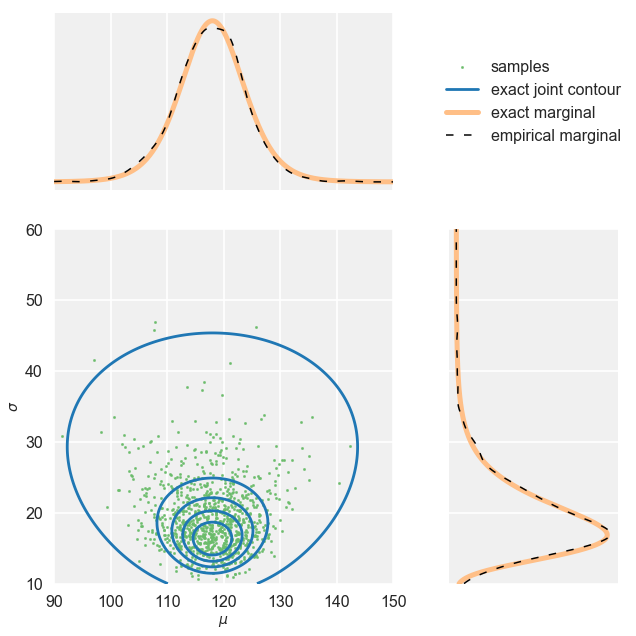

In [72]:
print('Joint and marginal posterior distributions')

# create figure
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# plot the joint distribution
ax = axes[1, 0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma$', fontsize='14')

# plot the marginal of mu
ax = axes[0, 0]
# exact
ax.plot(
    t1,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
ax.plot(
    t1,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# plot the marginal of sigma
ax = axes[1, 1]
# exact
exact_line, = ax.plot(
    pm_sigma,
    t2,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
empirical_line, = ax.plot(
    pk_sigma,
    t2,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

# hide last ax
ax = axes[0, 1]
ax.axis('off')
# make legend there
ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

fig.tight_layout()

Visualise factored sampling and the corresponding marginal and conditional densities.

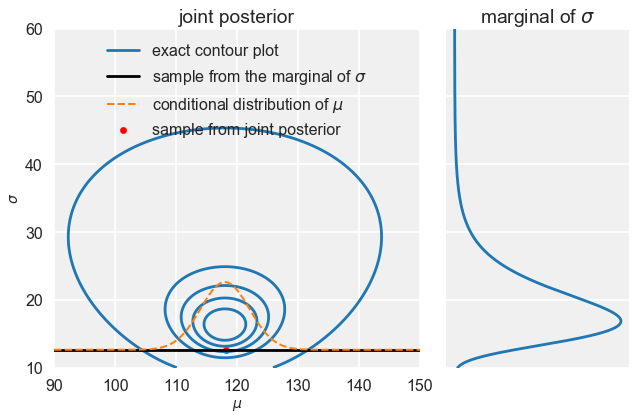

In [73]:
# create figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# plot the joint distribution
ax = axes[0]
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    t1,
    sigma[0] + stats.norm.pdf(t1, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# plot the marginal of sigma
ax = axes[1]
ax.plot(pm_sigma, t2)
# decorate
ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

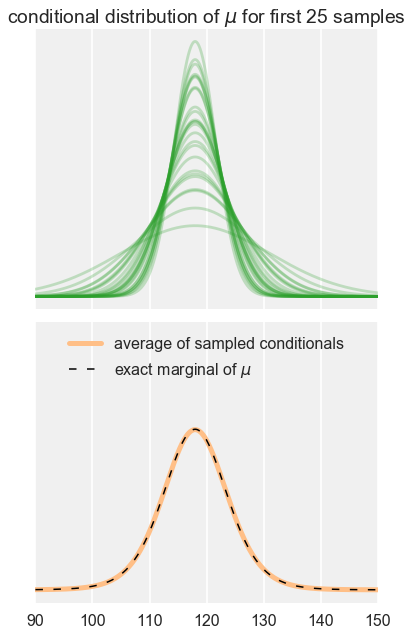

In [75]:
#  calculate conditional pdfs for each sample
condpdfs = stats.norm.pdf(t1, my, np.sqrt(sigma2/n)[:,np.newaxis])

# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# plot some of them
ax = axes[0]
ax.plot(t1, condpdfs[:25].T, 'C2', alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# plot their mean
ax = axes[1]
ax.plot(
    t1,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    t1,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

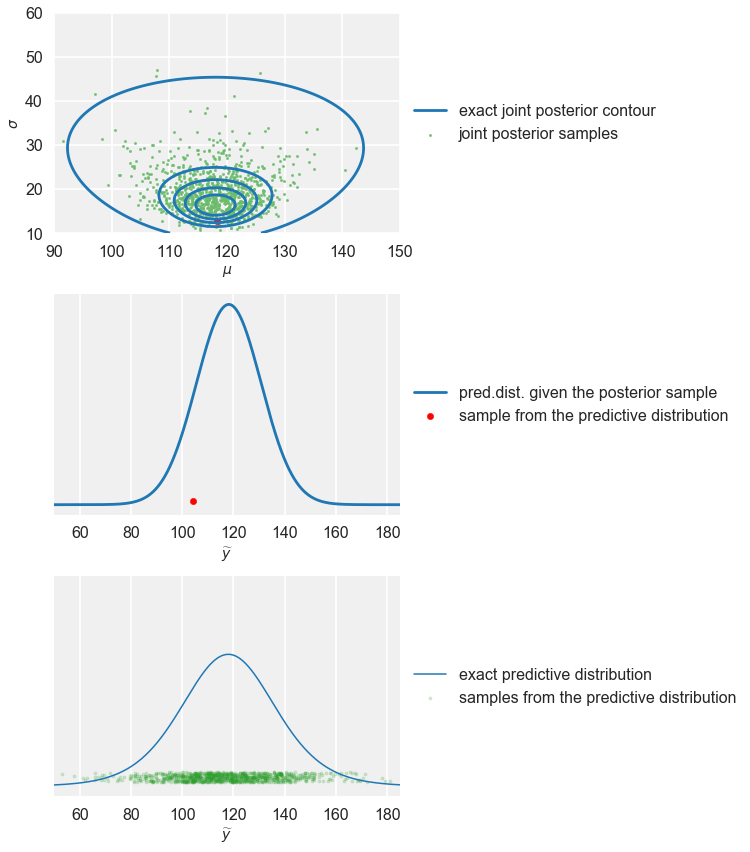

In [78]:
# calculate predictive pdf for the first given mu and sigma sample
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# plot the joint distribution
ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# plot first ynew
ax = axes[1]
# plot the distribution and the respective sample
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')
# decorate
ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# plot all ynews
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists),
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

# Hierarchical Model

In [41]:
tumordata = pd.read_table('../data/rattumour.txt', header=0, sep='\s+')
tumory = tumordata.y[:-1].values
tumorn = tumordata.N[:-1].values

In the 71st experiment, we are told that 4 out of 14 rats develop tumors. Our problem is to estimate the risk of tumor in the rats in the 71st experiment.

Thus we are considering the problem of estimating the tumor rate from a small experiment (no 71) and a prior constructed from previous experiments with similar structure. Mathematically, we consider the current and historical experiments as random samples from a common population.

In [6]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

(array([14.,  8., 14.,  3.,  3., 13.,  6.,  2.,  6.,  1.]),
 array([0.    , 0.0375, 0.075 , 0.1125, 0.15  , 0.1875, 0.225 , 0.2625,
        0.3   , 0.3375, 0.375 ]),
 <a list of 10 Patch objects>)

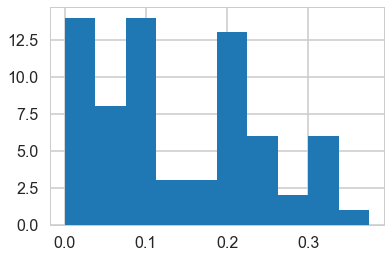

In [7]:
plt.hist(tumor_rat)

# Modeling

Since a rat is either have or don't have the tumor, it makes sense to use a Binomial model for **each** experiment, assumming a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments, we have the likelihood: $$p(y_i|\theta_i, n_i) = Binom(n_i, y_i, \theta_i)$$

Then for all the experiment we have the likelihood: $$p(Y|\Theta, \{n_i\}) = \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)$$

### Picking prior $p(\Theta)$

### No pooling

Our first thought is to use Beta (conjugate prior to Binomial) for each $\theta_i$:

$$\begin{align}\theta_i &\sim Beta(\alpha_i, \beta_i)\\
p(\Theta|\{\alpha_i\},\{\beta_i\}) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha_i, \beta_i)
\end{align}$$

where $\alpha_i$ and $\beta_i$ are **hyperparameters**.

These will leads to a very overfit models with 210 parameters and not much data. This model will have a large amount of variance, i.e, it is sensitive to outliers.

### Full pooling
The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance. Thus such a model might thus be underfit, unable to capture the variations in the samples. This is likely a model with a large amount of bias.

### Partial pooling 

We compromise and assume that each $\theta_i$ are drawn from a population distribution given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$\begin{align}\theta_i &\sim Beta(\alpha, \beta)\\
p(\Theta| \alpha, \beta) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)
\end{align}$$

The structure of this model is shown as follows: ![](./gfx/rat_model.png)

Models such as the one above are called **hierarchical model**, with observable outcomes ($Y_i$) modeled conditionally on certain parameters ($\theta_i)$, which themselves are given a probabilistic specification in terms of hyperparameters.

Modeling in this way has two advantages:

1. It helps us develop a computational strategy to solve the problem

2. It allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps “regularize” this.

# Full Bayesian Treatment 1

# Full Bayesian Treatment 2

In this section, we repeat the same experiment but using different Metropolis-Hasting sampling methods.

In our rat tumor example, we have the hyperparameters are $(\alpha, \beta)$, which controls the distrubtion of parameters $\theta_j$, and $(y_j, n_j)$ as observed data. Then in a full Bayesian treatment, we need to derive analytically the following distributions:

1. joint posterior density of (hyper)parameters: $p(\theta, \phi|y) \propto p(\phi)p(\theta|\phi)p(y|\theta)$
2. conditional posterior densityo of parameters $\theta$: $p(\theta|\phi, y)$
3. estimate hyperparameters $\phi$ by derive its marginal posterior distribution $p(\phi \mid y) = \frac{p(\theta, \phi \mid y)}{p(\theta \mid \phi, y)}$ (conditional probability formula).

Applying these steps to the rat tumors we have.

**Step 1**: $$\begin{align}p(\Theta, \alpha, \beta \mid Y, \{n_i\})&\propto p(\alpha, \beta)p(\Theta|\alpha, \beta)p(y|\Theta, \alpha,\beta)\\&\propto p(\alpha, \beta) \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)\prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)\end{align}$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

**Step 2**:  The **conditional** posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i  \vert  y_i, n_i, \alpha, \beta) = Beta(\theta_i, \alpha + y_i, \beta + n_i - y_i)$ 

**Step 3**: For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha  \vert  Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta  \vert  Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Hyperprior construction

In order to perform full bayesian treatment, we need to specify a hyper-priors, $p(\alpha, \beta)$, on these hyperparameters $(\alpha, \beta)$. Since we do not have any knowledge on the rate of tumors in rat experiments, we may wish to assign an improper prior distribution for the hyperparameters, $(\alpha, \beta)$, we must check that the posterior distribution $p(\alpha, \beta \mid y)$ is proper.

See the BDA book (p. 110) for the construction of the hyperpriors.

We select the prior $p(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$

# Sampling

In [8]:
# number of thetas
numthetas=tumorn.shape[0]
numthetas

70

We peform sampling from conditional posterior distribution of $\alpha$, $\beta$ and $\theta$ using Metropolis-Hastings style sampler.

In [9]:
from scipy.special import gammaln

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

In [12]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

In [13]:
start = time.clock()

In [14]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

In [15]:
accepteds['alpha']/numtraces, accepteds['beta']/numtraces

(0.360055, 0.430505)

In [29]:
#remove burnin samples and thin
thin=40
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetatrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

(5000, 70) (5000,)


Text(0,0.5,'beta')

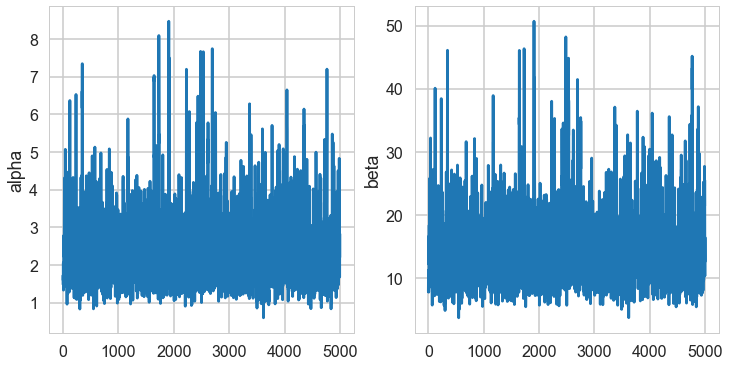

In [20]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')

In [38]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

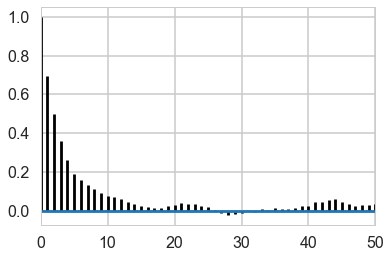

In [39]:
corrplot(alphatrace)


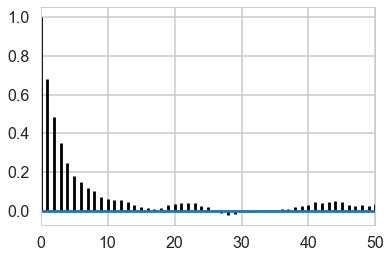

In [40]:
corrplot(betatrace)


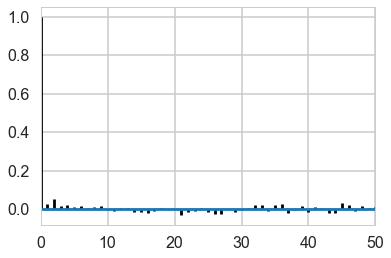

In [41]:
corrplot(thetastrace[:,7])


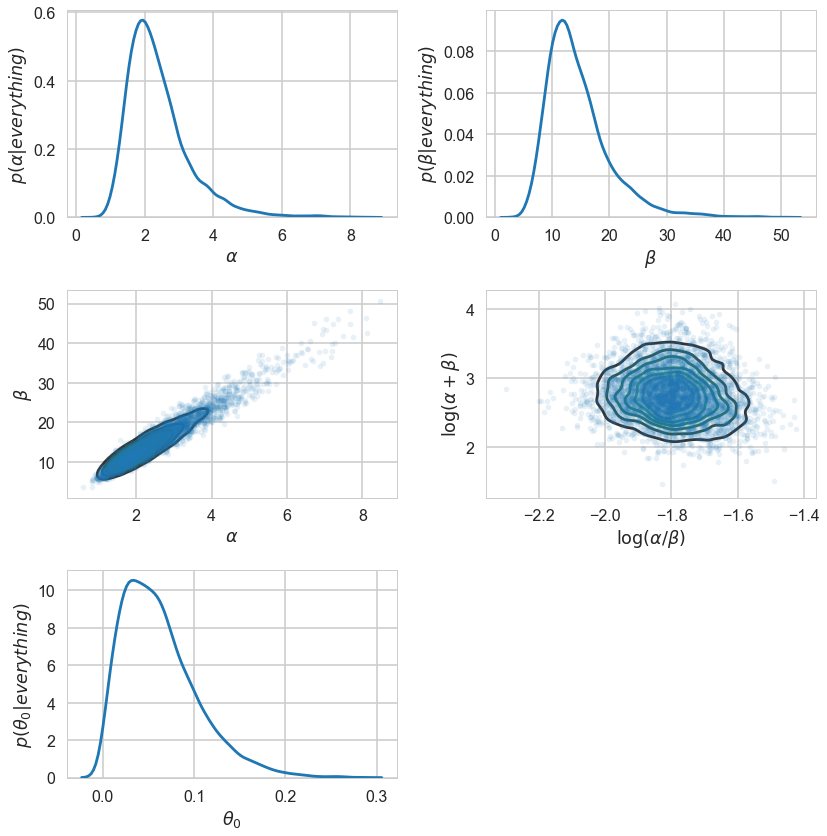

In [37]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$p(\alpha \vert  everything)$')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$p(\beta \vert  everything)$')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel(r'$\log(\alpha/\beta)$')
plt.ylabel(r'$\log(\alpha+\beta)$')

plt.subplot(3,2,5)
sns.kdeplot(thetatrace[:,0])
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$p(\theta_0 \vert  everything)$')
plt.tight_layout()


In [22]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

In [24]:
empirical_ratios=tumory/tumorn


(-0.1, 0.5)

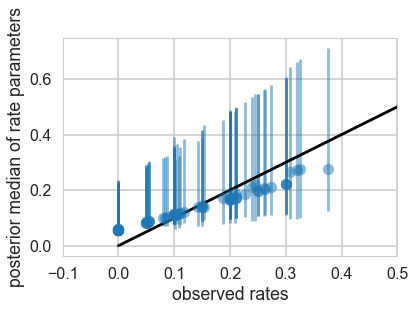

In [25]:
plt.errorbar(empirical_ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")
plt.xlim(-0.1,0.5)


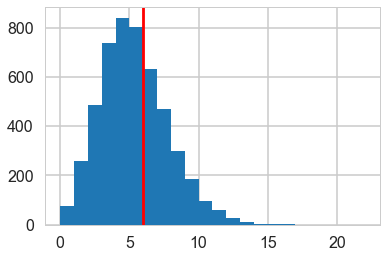

In [26]:
from scipy.stats import binom
pred60 = binom.rvs(tumorn[60],thetastrace[:,60])
plt.hist(pred60, bins=np.arange(tumorn[60]));
plt.axvline(tumory[60],0,1,color='r');

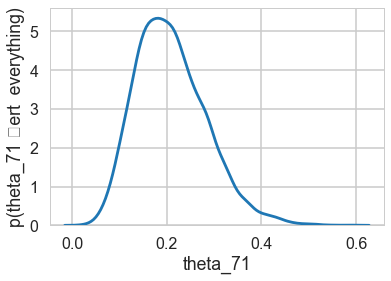

In [27]:
post71 = beta.rvs(alphatrace+4, betatrace+10)
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)');

In [28]:
# numpy function falttens by default
percentiles =np.percentile(post71, [2.5,50.0, 97.5])

print("Percentiles: ", percentiles)
print("Naive rate: ", 4.0/14)

Percentiles:  [0.08865296 0.20118033 0.37370005]
Naive rate:  0.2857142857142857
